# Лабораторная работа по теме "Классификация текста"
Выполнил: Пакало Александр Сергеевич ИУ5-22М

## Задание
Для произвольного набора данных, предназначенного для классификации текстов, решите задачу классификации текста двумя способами:

- Способ 1. На основе CountVectorizer или **TfidfVectorizer**.
- Способ 2. На основе моделей **word2vec** или Glove или fastText.

Сравните качество полученных моделей.
Для поиска наборов данных в поисковой системе можно использовать ключевые слова "datasets for text classification".

In [58]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [1]:
RANDOM_SEED = 13

## Набор данных
Проведём классификацию текста используя набор данных [BBC News Archive](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive)

Подготовка переменных для работы с данными

In [2]:
from pathlib import Path

data_path = Path("../../data")
external_data_path = data_path / "external"
raw_data_path = data_path / "raw"

dataset_filename = "bbc-news-data.zip"

Разархивирование набора данных

In [3]:
import os
import shutil

raw_data_path.mkdir(exist_ok=True)

file_path = external_data_path / dataset_filename
raw_data_path = external_data_path / dataset_filename

if not os.path.isfile(raw_data_path):
    shutil.unpack_archive(file_path, extract_dir=raw_data_path)
    # file_path.unlink()  # Remove archive after extracting it.

Загрузка данных из csv

In [4]:
import pandas as pd

df = pd.read_csv(raw_data_path, sep="\t")

### Разведочный анализ данных
Ознакомимся немного с данными, с которыми собираемся работать

Основные характеристики датасета

In [5]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [6]:
df.tail()

,category,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


Размер датасета

In [7]:
num_of_rows, num_of_columns = df.shape
print(f'Размер датасета: {num_of_rows} строк, {num_of_columns} колонок')

Размер датасета: 2225 строк, 4 колонок


Определение типов

In [8]:
df.dtypes

category    object
filename    object
title       object
content     object
dtype: object

Проверка на наличие пустых значений

In [9]:
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

Обработки пустых значений не требуется

Проверка на уникальные значения

In [10]:
pd.Series(df["category"].unique())

0         business
1    entertainment
2         politics
3            sport
4             tech
dtype: object

### Подготовка корпуса

Некоторые колонки имеют неверные типы данных, их следует преобразовать.

Строки вместо `object` сделаем `string`, а колонку "category" сделаем
типа `category`.

In [11]:
df = df.astype({
    "category": "category",
    "filename": "string",
    "title": "string",
    "content": "string",
})
df.dtypes

category          category
filename    string[python]
title       string[python]
content     string[python]
dtype: object

Токенизация

Загрузка модели spacy.

In [12]:
import spacy

spacy_prefers_gpu = spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

Токенизация текстовых значений набора данных (кроме названия файла)

In [13]:
from spacy.tokens.doc import Doc

corpus: list[Doc] = []

for text in (df["title"] + df["content"]).values:
    corpus.append(nlp(text))

corpus[:3]

[Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

In [14]:
assert len(corpus) == num_of_rows

Заметим, что spacy при печати и выводит текст, на самом деле это объект.
Word2Vec ожидает увидеть строки либо списки.

In [15]:
spacy_text = nlp('training: nlp!')
spacy_text, type(spacy_text), type(spacy_text[0])

(training: nlp!, spacy.tokens.doc.Doc, spacy.tokens.token.Token)

In [16]:
[token.text for token in spacy_text]

['training', ':', 'nlp', '!']

Поэтому преобразуем наш `corpus` в упрощённый формат, совместимый с word2vec.

In [17]:
corpus_for_word2vec = [[token.text for token in spacy_text] for spacy_text in corpus]

corpus_for_word2vec[:3]

[['Ad',
  'sales',
  'boost',
  'Time',
  'Warner',
  'profit',
  'Quarterly',
  'profits',
  'at',
  'US',
  'media',
  'giant',
  'TimeWarner',
  'jumped',
  '76',
  '%',
  'to',
  '$',
  '1.13bn',
  '(',
  '£',
  '600',
  'm',
  ')',
  'for',
  'the',
  'three',
  'months',
  'to',
  'December',
  ',',
  'from',
  '$',
  '639',
  'm',
  'year',
  '-',
  'earlier',
  '.',
  ' ',
  'The',
  'firm',
  ',',
  'which',
  'is',
  'now',
  'one',
  'of',
  'the',
  'biggest',
  'investors',
  'in',
  'Google',
  ',',
  'benefited',
  'from',
  'sales',
  'of',
  'high',
  '-',
  'speed',
  'internet',
  'connections',
  'and',
  'higher',
  'advert',
  'sales',
  '.',
  'TimeWarner',
  'said',
  'fourth',
  'quarter',
  'sales',
  'rose',
  '2',
  '%',
  'to',
  '$',
  '11.1bn',
  'from',
  '$',
  '10.9bn',
  '.',
  'Its',
  'profits',
  'were',
  'buoyed',
  'by',
  'one',
  '-',
  'off',
  'gains',
  'which',
  'offset',
  'a',
  'profit',
  'dip',
  'at',
  'Warner',
  'Bros',
  ',',
  

## Модель word2vec
Список доступных предобученнных моделей

In [18]:
from gensim.downloader import info

list(info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

Загрузка модели

In [19]:
from gensim.downloader import info, load

# You can safely restart this cell, gensim will download it only once.
# It still takes some time to load, though.
word2vec_google_news_300_model = load("word2vec-google-news-300")

Небольшая проверка работы модели

In [20]:
words = ["king", "queen", "man", "woman"]

In [21]:
from itertools import permutations

PAIRS = 2
[f"Для пары слов {word_pair} схожесть: {word2vec_google_news_300_model.similarity(*word_pair):1.2f}" for word_pair in permutations(words, PAIRS)]

["Для пары слов ('king', 'queen') схожесть: 0.65",
 "Для пары слов ('king', 'man') схожесть: 0.23",
 "Для пары слов ('king', 'woman') схожесть: 0.13",
 "Для пары слов ('queen', 'king') схожесть: 0.65",
 "Для пары слов ('queen', 'man') схожесть: 0.17",
 "Для пары слов ('queen', 'woman') схожесть: 0.32",
 "Для пары слов ('man', 'king') схожесть: 0.23",
 "Для пары слов ('man', 'queen') схожесть: 0.17",
 "Для пары слов ('man', 'woman') схожесть: 0.77",
 "Для пары слов ('woman', 'king') схожесть: 0.13",
 "Для пары слов ('woman', 'queen') схожесть: 0.32",
 "Для пары слов ('woman', 'man') схожесть: 0.77"]

### Обучение собственной модели

In [22]:
corpus[0].text

'Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

In [23]:
from gensim.models import word2vec

model_trained_on_dataset: word2vec.Word2Vec

%time model_trained_on_dataset = word2vec.Word2Vec(corpus_for_word2vec, workers=8, min_count=10, window=10, sample=1e-3)

CPU times: user 3.55 s, sys: 5.56 ms, total: 3.56 s
Wall time: 764 ms


In [24]:
wv = model_trained_on_dataset.wv

In [25]:
for index, word in enumerate(wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(wv.index_to_key)} is {word}")

word #0/7528 is the
word #1/7528 is .
word #2/7528 is ,
word #3/7528 is to
word #4/7528 is "
word #5/7528 is of
word #6/7528 is and
word #7/7528 is a
word #8/7528 is in
word #9/7528 is -


In [26]:
wv['the']

array([ 2.2328116e-03,  1.3145196e+00,  4.8119223e-01,  8.2273012e-01,
       -7.3784679e-01,  1.1799921e-01,  1.2944862e-01, -1.8478009e-01,
       -9.5712818e-02,  4.8478240e-01,  1.3814596e+00,  6.6620255e-01,
       -4.7658932e-01,  3.2528889e-01, -7.1216339e-01,  5.6120133e-01,
        8.8995785e-01, -4.8151794e-01, -1.4412236e+00, -1.8842486e+00,
        1.0169474e+00,  8.3980924e-01,  2.4093542e+00, -9.2637980e-01,
       -8.3508015e-01,  9.9907434e-01, -5.7357568e-01, -1.4646709e+00,
       -6.7030293e-01, -3.8889077e-01, -7.6762259e-01,  2.7496248e-01,
        1.0931668e+00,  6.8747324e-01,  6.2028271e-01, -3.3290204e-01,
        5.7881808e-01,  5.3475720e-01,  1.8358558e-01,  2.6981041e-01,
       -2.4757305e-01,  2.0826844e-02, -4.2661145e-01,  3.0817699e-01,
       -2.9780325e-01,  9.1499192e-01, -1.1656585e+00,  1.4410807e+00,
        1.2741096e+00, -6.7983754e-02, -1.7749549e+00, -1.9587585e-01,
        2.4553971e-01, -7.5158238e-01,  5.5168909e-01, -1.2906446e-01,
      

In [27]:
model_trained_on_dataset.wv.most_similar(positive=['the'], topn=5)

[('tackled', 0.5361359715461731),
 ('question', 0.5353929400444031),
 ('House', 0.5064075589179993),
 ('another', 0.49653181433677673),
 ('course', 0.4722856879234314)]

## Классификация

### Подготовка данных для классификации

Выберем `X` и `y` среди нашего набора данных

In [28]:
X = corpus_for_word2vec
y = df["category"].values

Составим выборки для обучения

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=RANDOM_SEED
)

Аналогичные выборки сделаем для моделей, которые в себя принимают список
строк, а не список токенов.

In [30]:
X_str = [spacy_text.text for spacy_text in corpus]

In [31]:
from sklearn.model_selection import train_test_split

X_str_train, X_str_test, y_str_train, y_str_test = train_test_split(
    X_str, y,
    test_size=0.33,
    random_state=RANDOM_SEED
)

### Составим pipeline

Подготовим scaler'ы для последующих моделей.

Например, NaiveBayes умеет работать только с неотрицательными числами.

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

Составим pipeline

In [33]:
import numpy as np
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score


def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """

    accs = accuracy_score_for_classes(y_true, y_pred)
    results = pd.DataFrame(data={ "Категория": accs.keys(), "Точность": accs.values() })

    display(results)

    return results

In [34]:
class EmbeddingVectorizer(object):
    '''
    Для текста усредним вектора входящих в него слов
    '''
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean(
            [self.model[w] for w in words if w in self.model] 
            or [np.zeros(self.size)], axis=0)
            for words in X])

In [35]:
from sklearn.pipeline import Pipeline


def classifier_pipeline(v, c, scaler=None, corpus_already_tokenized=True):
    pipeline_steps = [
        ("vectorizer", v), 
    ]

    if scaler:
        pipeline_steps.append(("scaler", scaler))

    pipeline_steps.append(("classifier", c))

    pipeline = Pipeline(pipeline_steps)

    classifier_X_train = X_train
    classifier_y_train = y_train
    classifier_X_test = X_test
    classifier_y_test = y_test

    if not corpus_already_tokenized:
        classifier_X_train = X_str_train
        classifier_y_train = y_str_train
        classifier_X_test = X_str_test
        classifier_y_test = y_str_test

    pipeline.fit(classifier_X_train, classifier_y_train)
    y_pred = pipeline.predict(classifier_X_test)

    return print_accuracy_score_for_classes(classifier_y_test, y_pred)

### Проверка результатов

In [36]:
ClassifierName = str
ModelName = str

metrics_data: dict[ClassifierName, dict[ModelName, float]] = {}

In [37]:
def add_metrics_data(classier_name: ClassifierName, model_name: ModelName, results: pd.DataFrame):
    if not metrics_data.get(classier_name):
        metrics_data[classier_name] = {}

    metrics_data[classier_name][model_name] = np.mean(results['Точность'])

    return metrics_data

### Протестируем собственно-обученную модель Word2Vec.

#### LogisticRegression

In [38]:
add_metrics_data("LogisticRegression", "our w2v", classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), LogisticRegression(C=5.0)))

/home/ds13/Projects/--educational/Bmstu__/t5-2-/MachineLearningMethods__/t5-2-MachineLearningMethods__Fundamentals/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Категория,Точность
0,business,0.861635
1,entertainment,0.766423
2,politics,0.870504
3,sport,0.924528
4,tech,0.879433


{'LogisticRegression': {'our w2v': 0.8605046201825178}}

LogisticRegression с min_max_scaler

In [39]:
add_metrics_data("LogisticRegression with scaler", "our w2v", classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), LogisticRegression(C=5.0), scaler=min_max_scaler))

/home/ds13/Projects/--educational/Bmstu__/t5-2-/MachineLearningMethods__/t5-2-MachineLearningMethods__Fundamentals/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Категория,Точность
0,business,0.861635
1,entertainment,0.781022
2,politics,0.884892
3,sport,0.924528
4,tech,0.865248


{'LogisticRegression': {'our w2v': 0.8605046201825178},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176}}

#### MultinomialNaiveBayes

In [40]:
from sklearn.naive_bayes import MultinomialNB

# NB нужны неотрицательные значения.
add_metrics_data("MultinomialNB", "our w2v", classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), MultinomialNB(), scaler=min_max_scaler))

,Категория,Точность
0,business,0.792453
1,entertainment,0.554745
2,politics,0.791367
3,sport,0.779874
4,tech,0.801418


{'LogisticRegression': {'our w2v': 0.8605046201825178},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176},
 'MultinomialNB': {'our w2v': 0.743971383152747}}

#### KNeighborsClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# KNC нужны значения, распределённые по нормальному распределению.
add_metrics_data("KNeighborsClassifier", "our w2v", classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), KNeighborsClassifier(n_neighbors=15), scaler=standard_scaler))

,Категория,Точность
0,business,0.836478
1,entertainment,0.708029
2,politics,0.856115
3,sport,0.893082
4,tech,0.858156


{'LogisticRegression': {'our w2v': 0.8605046201825178},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176},
 'MultinomialNB': {'our w2v': 0.743971383152747},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858}}

#### DecisionTreeClassifier

In [42]:
from sklearn.tree import DecisionTreeClassifier

classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), DecisionTreeClassifier(max_depth=20, criterion="gini"))

,Категория,Точность
0,business,0.735849
1,entertainment,0.635036
2,politics,0.762590
3,sport,0.792453
4,tech,0.822695


,Категория,Точность
0,business,0.735849
1,entertainment,0.635036
2,politics,0.762590
3,sport,0.792453
4,tech,0.822695


In [43]:
classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), DecisionTreeClassifier(max_depth=60, criterion="gini"))

,Категория,Точность
0,business,0.729560
1,entertainment,0.598540
2,politics,0.741007
3,sport,0.817610
4,tech,0.787234


,Категория,Точность
0,business,0.729560
1,entertainment,0.598540
2,politics,0.741007
3,sport,0.817610
4,tech,0.787234


In [44]:
add_metrics_data("DecisionTreeClassifier", "our w2v", classifier_pipeline(EmbeddingVectorizer(model_trained_on_dataset.wv), DecisionTreeClassifier(max_depth=200, criterion="gini")))

,Категория,Точность
0,business,0.779874
1,entertainment,0.620438
2,politics,0.733813
3,sport,0.805031
4,tech,0.829787


{'LogisticRegression': {'our w2v': 0.8605046201825178},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176},
 'MultinomialNB': {'our w2v': 0.743971383152747},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158}}

### Протестируем предобученную модель от google Word2Vec.

#### LogisticRegression

In [45]:
add_metrics_data("LogisticRegression", "google w2v", classifier_pipeline(EmbeddingVectorizer(word2vec_google_news_300_model), LogisticRegression(C=5.0)))

,Категория,Точность
0,business,0.943396
1,entertainment,0.963504
2,politics,0.949640
3,sport,0.993711
4,tech,0.971631


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176},
 'MultinomialNB': {'our w2v': 0.743971383152747},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158}}

LogisticRegression с min_max_scaler

In [46]:
add_metrics_data("LogisticRegression with scaler", "google w2v", classifier_pipeline(EmbeddingVectorizer(word2vec_google_news_300_model), LogisticRegression(C=5.0), scaler=min_max_scaler))

,Категория,Точность
0,business,0.955975
1,entertainment,0.978102
2,politics,0.942446
3,sport,0.993711
4,tech,0.992908


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158}}

#### MultinomialNaiveBayes

In [47]:
from sklearn.naive_bayes import MultinomialNB

# NB нужны неотрицательные значения.
add_metrics_data("MultinomialNB", "google w2v", classifier_pipeline(EmbeddingVectorizer(word2vec_google_news_300_model), MultinomialNB(), scaler=min_max_scaler))

,Категория,Точность
0,business,0.924528
1,entertainment,0.905109
2,politics,0.949640
3,sport,0.987421
4,tech,0.929078


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158}}

#### KNeighborsClassifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# KNC нужны значения, распределённые по нормальному распределению.
add_metrics_data("KNeighborsClassifier", "google w2v", classifier_pipeline(EmbeddingVectorizer(word2vec_google_news_300_model), KNeighborsClassifier(n_neighbors=15), scaler=standard_scaler))

,Категория,Точность
0,business,0.905660
1,entertainment,0.948905
2,politics,0.971223
3,sport,1.000000
4,tech,0.964539


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858,
  'google w2v': 0.9580655031044948},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158}}

#### DecisionTreeClassifier

In [49]:
from sklearn.tree import DecisionTreeClassifier

add_metrics_data("DecisionTreeClassifier", "google w2v", classifier_pipeline(EmbeddingVectorizer(word2vec_google_news_300_model), DecisionTreeClassifier(max_depth=200, criterion="gini")))

,Категория,Точность
0,business,0.880503
1,entertainment,0.795620
2,politics,0.834532
3,sport,0.949686
4,tech,0.836879


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858,
  'google w2v': 0.9580655031044948},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158,
  'google w2v': 0.8594441847852641}}

### TFIDF
Scaler не нужен (и его даже невозможно применить, ведь tfidf возвращает
разреженную матрицу)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,3))

#### LogisticRegression

In [51]:
add_metrics_data("LogisticRegression", "tfidf", classifier_pipeline(tfidf, LogisticRegression(C=5.0), corpus_already_tokenized=False))

,Категория,Точность
0,business,0.955975
1,entertainment,0.919708
2,politics,0.971223
3,sport,0.993711
4,tech,0.992908


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148,
  'tfidf': 0.9667048773578898},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858,
  'google w2v': 0.9580655031044948},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158,
  'google w2v': 0.8594441847852641}}

#### MultinomialNaiveBayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

# NB нужны неотрицательные значения.
add_metrics_data("MultinomialNB", "tfidf", classifier_pipeline(tfidf, MultinomialNB(), corpus_already_tokenized=False))

,Категория,Точность
0,business,0.974843
1,entertainment,0.598540
2,politics,0.949640
3,sport,1.000000
4,tech,0.921986


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148,
  'tfidf': 0.9667048773578898},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735,
  'tfidf': 0.8890018033307239},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858,
  'google w2v': 0.9580655031044948},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158,
  'google w2v': 0.8594441847852641}}

#### KNeighborsClassifier

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# KNC нужны значения, распределённые по нормальному распределению.
add_metrics_data("KNeighborsClassifier", "tfidf", classifier_pipeline(tfidf, KNeighborsClassifier(n_neighbors=15), corpus_already_tokenized=False))

,Категория,Точность
0,business,0.874214
1,entertainment,0.868613
2,politics,0.964029
3,sport,0.981132
4,tech,0.950355


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148,
  'tfidf': 0.9667048773578898},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735,
  'tfidf': 0.8890018033307239},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858,
  'google w2v': 0.9580655031044948,
  'tfidf': 0.9276684875086623},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158,
  'google w2v': 0.8594441847852641}}

#### DecisionTreeClassifier

In [54]:
from sklearn.tree import DecisionTreeClassifier

add_metrics_data("DecisionTreeClassifier", "tfidf", classifier_pipeline(tfidf, DecisionTreeClassifier(max_depth=200, criterion="gini"), corpus_already_tokenized=False))

,Категория,Точность
0,business,0.748428
1,entertainment,0.656934
2,politics,0.719424
3,sport,0.880503
4,tech,0.709220


{'LogisticRegression': {'our w2v': 0.8605046201825178,
  'google w2v': 0.9643764122635148,
  'tfidf': 0.9667048773578898},
 'LogisticRegression with scaler': {'our w2v': 0.8634651466208176,
  'google w2v': 0.9726283137912249},
 'MultinomialNB': {'our w2v': 0.743971383152747,
  'google w2v': 0.9391554953079735,
  'tfidf': 0.8890018033307239},
 'KNeighborsClassifier': {'our w2v': 0.8303720163580858,
  'google w2v': 0.9580655031044948,
  'tfidf': 0.9276684875086623},
 'DecisionTreeClassifier': {'our w2v': 0.7537887600529158,
  'google w2v': 0.8594441847852641,
  'tfidf': 0.7429018885534178}}

### Сравнение результатов

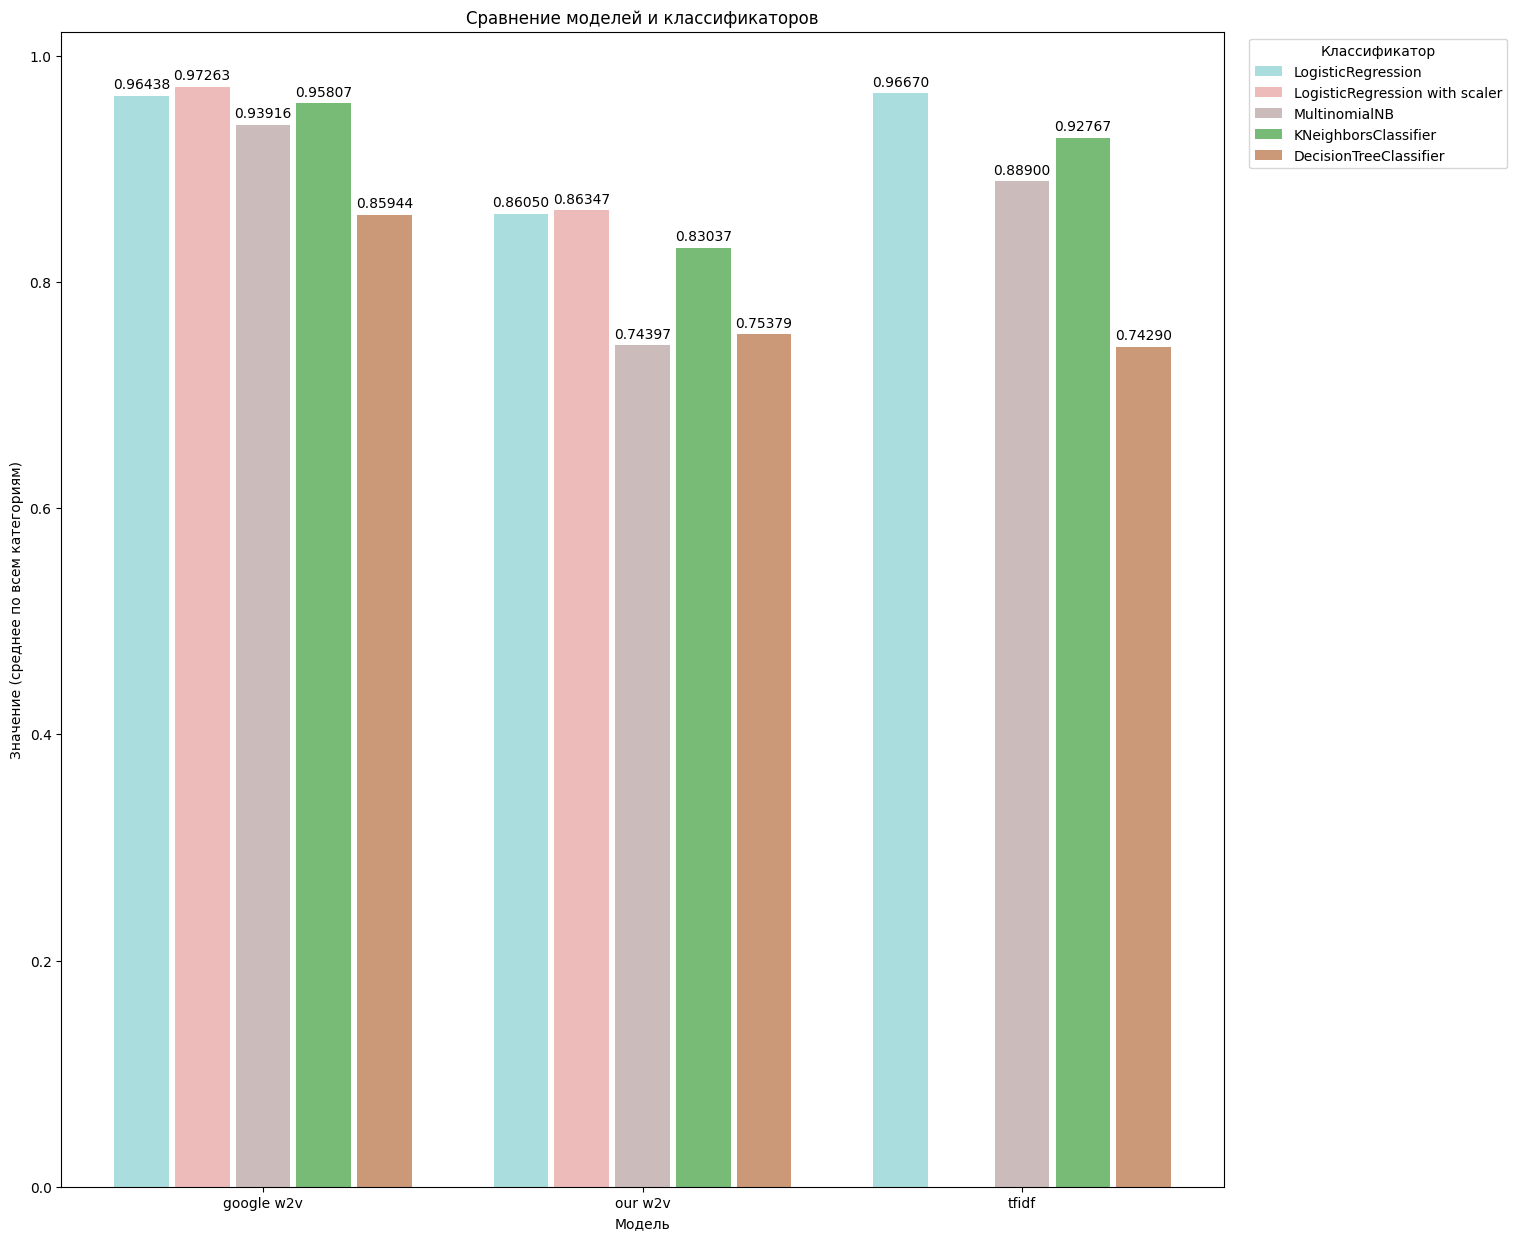

In [62]:
# Reloading editable packages.
%autoreload
from charts.main import grouped_bar_chart, get_metrics_grouped_bar_chart

models_bar_chart = get_metrics_grouped_bar_chart(metrics_data)
models_bar_chart["plt"].title('Сравнение моделей и классификаторов')
models_bar_chart["plt"].xlabel('Модель')
models_bar_chart["plt"].ylabel('Значение (среднее по всем категориям)')

models_bar_chart["ax"].legend(title='Классификатор', bbox_to_anchor=(1.25, 1))

models_bar_chart["plt"].show()

> У TFIDF нет "LogisticRegression with scaler", потому что scaler не нужен (и его невозможно применить для разреженной матрицы).

## Вывод
Как видно по графику сравнения моделей и классификаторов, наиболее успешной оказалась связка word2vector, предобученная google, и логистической регрессии со scaler'ом.

В среднем, модель от google продемонстрировала самый высокий результат для любого классификатора. Единственное исключение - логистическая регрессия для tfidf. Это комбинация показала
очень хороший результат, который лишь немного отстаёт от лучших значений google word2vector.

Так, видно, что в среднем tfidf достигает показателей лишь на 2-5 процентов хуже google2vector. Учитывая простоту алгоритма, это удивительный результат.

Обученная нами модель word2vec даёт в лучшем варианте 86%, что является вполне приемлемым. Однако в среднем у неё самые плохие результаты среди рассматриваемых моделей.
Это довольно неожиданно, ведь обучение и тренировка на данных из одной предметной области должны были дать лучшее качество.

Пытаясь найти причины, первым приходит на ум недостаток данных: наш набор не очень спефичный и на несколько порядков меньше набора данных google. Но в то же время
объём нашей выборки хоть и составляет несколько тысяч строк, в каждой из них есть ячейка с содержанием полноценной статьи, то есть количество токенов должно отвечать
запросам word2vec.

Вероятно, первопричина кроется в качестве самого обучения: мы мало проводили работы с корпусом токенов. Сразу после разбиения текста с помощью `spacy`
на токены, мы отправили модель обучаться. Вполне возможно, дополнительные оптимизации на уровне предложений и языка поспособствовали бы улучшению качества
модели. Например, устранение стоп-слов или очень частых слов, несущих малый смысл в рамках нашей задачи (союзы, предлоги), из выборки. На это ещё больше
намекает хороший результат TFIDF, ведь он эти оптимизации проводит "автоматически" ввиду особенностей формулы.

Таким образом, мы обучили три модели и сравнили показатели. Каждая из них даёт хорошие результаты в классификации, однако у всех моделей есть большой недостаток -
неумение работать со словами, не присутствующими в выборке. Наименее заметно это в google word2vector, ведь в ней набор данных колоссальный, однако если стоит задача
обрабатывать любые слова, лучше подойдёт принципиально модифицированная модель, например, fast2text.